In [81]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import shapiro

In [254]:
import warnings
warnings.filterwarnings('ignore')

# Hypothesis Testing

**Hypothesis**: University towns have their mean housing prices less effected by recessions. 

**Analytical Approach**: Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the end of the recession, relative to non-university towns. (`price_ratio=quarter_before_recession/recession_end`)

We'll use the following data sources to test this hypothesis:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, we'll only look at GDP data from 2000 onward.

In [271]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    #opens file, reads file (at this point '\n' separates each line in one long string), 
    #then splitlines() makes an array with each line it's own element
    open_file = open('/Users/Brian/Dropbox/Data_Science/Github_portfolio/Home_prices/university_towns.txt')
    contents = open_file.read()
    split_contents = contents.splitlines()
        
    #create dataframe from array and create second column with same data that we can now apply boolean mark to 
    df = pd.DataFrame(split_contents, columns = ['State'])
    df['RegionName'] = df['State']
    
    #use string manipulation to trim down state and region names
    df['State'] = df['State'].str.split('[').str[0]
    df['RegionName'] = df['RegionName'].str.split('(').str[0].str.split('[').str[0]
    df['RegionName'] = df['RegionName'].str.rstrip()
    
    #create loop to match column values with a dictionary of state names, return True or False
    #create dictionary of state names to match against
    states = {'Ohio','Kentucky','Nevada','Wyoming','Alabama','Maryland','Alaska','Utah','Oregon','Montana','Illinois','Tennessee','District of Columbia','Vermont','Idaho','Arkansas','Maine','Washington','Hawaii','Wisconsin','Michigan','Indiana','New Jersey','Arizona','Mississippi','North Carolina','Texas','South Dakota','Iowa','Missouri','Connecticut','West Virginia','South Carolina','Louisiana','Kansas','New York','Nebraska','Oklahoma','Florida','California','Colorado','Pennsylvania','Delaware','New Mexico','Rhode Island','Minnesota','New Hampshire','Massachusetts','Georgia','North Dakota', 'Virginia'}    
    
    for i in range(1, len(df)): 
    #the below checks if name in 'State' is in the 'states' dictionary, and if so equals itself, else equals the row above
        if df['State'][i] not in states:
            df['State'][i] = df['State'][i-1]
        
    #boolean mask to remove rows where state equals region name
    df = df[df['State'] != df['RegionName']]
    
    df['College Town'] = 'College Town'

    return df

college_towns = get_list_of_university_towns()
college_towns.head()

,State,RegionName,College Town
1,Alabama,Auburn,College Town
2,Alabama,Florence,College Town
3,Alabama,Jacksonville,College Town
4,Alabama,Livingston,College Town
5,Alabama,Montevallo,College Town


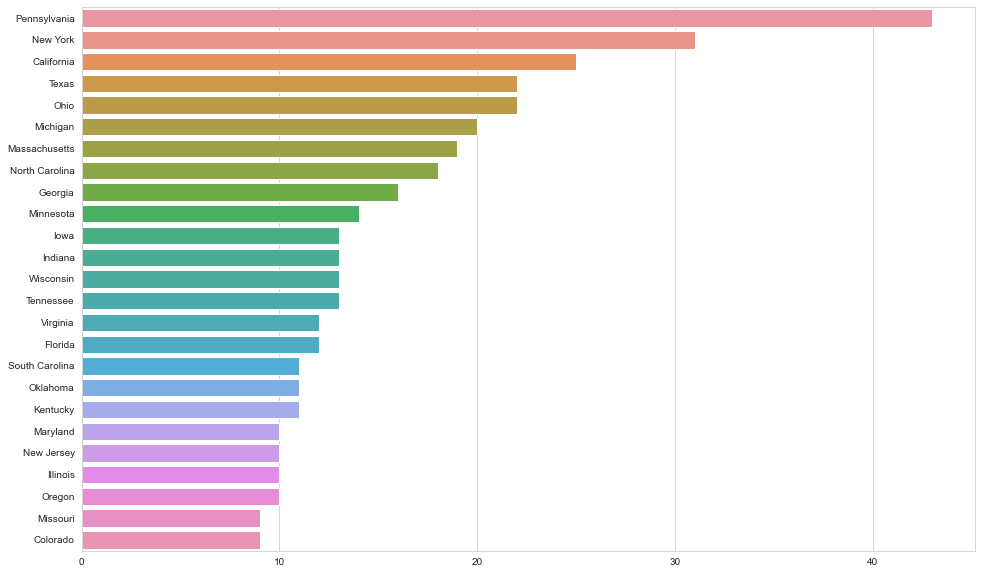

In [257]:
#plot college towns by state
college_towns_by_state = college_towns.State.value_counts()

sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.barplot(y=college_towns_by_state.index[0:25], x=college_towns_by_state.values[0:25])

In [255]:
def get_gdp():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    
    #read excel, skip first 5 rows, only include rows after year 2000 and columns 5-7, rename columns, drop na values
    df = pd.read_excel('/Users/Brian/Dropbox/Data_Science/Github_portfolio/Home_prices/gdplev.xls',skiprows=5).iloc[:,4:7].rename(columns={"Unnamed: 4": 'Year Qtr',
                    'GDP in billions of current dollars.1':'GDPCurrent', 
                    'GDP in billions of chained 2009 dollars.1':'GDP2009'})

    #find recession start (2 consecutive quarters of GDP decline, only looking after 2000)
    
    #create new empty column in df 
    df['Recession'] = np.nan
    #limit to years 2000-Present
    df = df.iloc[212:,:].reset_index()
    del df['index']
    
    #iterate over desired range and return 1 if 2 consecutive quarters of GDP decline
    for i in range(2,len(df)-1):
        if df['GDP2009'][i] < df['GDP2009'][i-1] and (df['GDP2009'][i-1] < df['GDP2009'][i-2]):
            df['Recession'][i] = 1
        else:
            df['Recession'][i] = 0
    
    #boolean mask to return only rows with recession
    df_recession = df[df['Recession'] == 1]
    
    return df, df_recession

df_gdp, df_gdp_recession = get_gdp()
df_gdp.head()

,Year Qtr,GDPCurrent,GDP2009,Recession
0,1999q3,9712.3,12113.1,NaN
1,1999q4,9926.1,12323.3,NaN
2,2000q1,10031.0,12359.1,0.0
3,2000q2,10278.3,12592.5,0.0
4,2000q3,10357.4,12607.7,0.0


Text(0, 0.5, 'GDP (Billions $)')

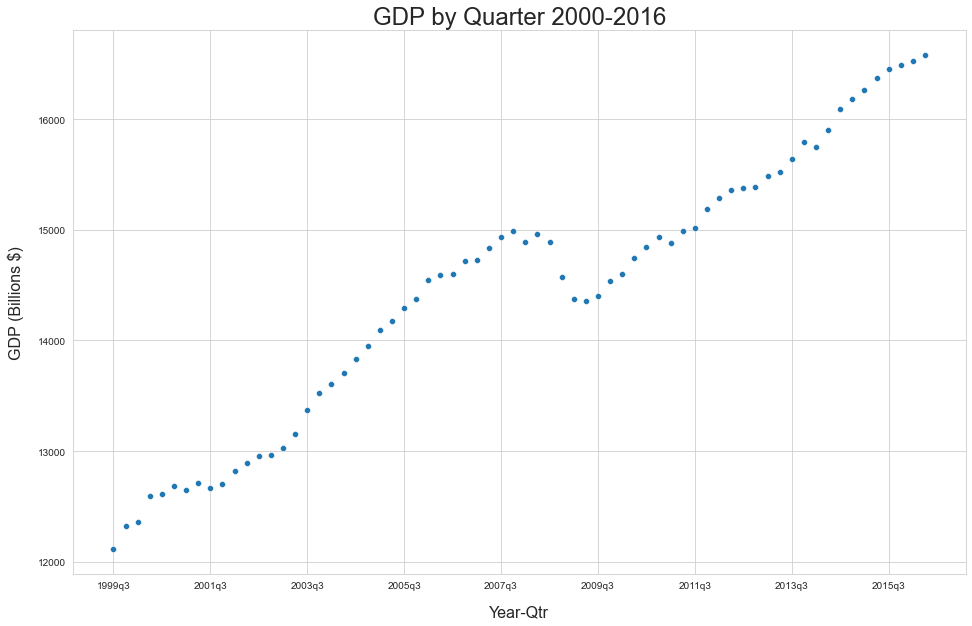

In [264]:
#plot gdp over time
fig, ax = plt.subplots(figsize=(16,10))

sns.scatterplot(x='Year Qtr',y='GDP2009', data=df_gdp, ax=ax)

ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))

plt.title('GDP by Quarter 2000-2016',fontsize=24)
plt.xlabel("Year-Qtr", labelpad=14, fontsize=16)
plt.ylabel("GDP (Billions $)", labelpad=14, fontsize=16)


In [267]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    
    gdp, df_gdp_recession = get_gdp()
    
    gdp['Growth'] = np.nan
    gdp['Recession End'] = np.nan
    
    #iterate over range and return 1 if 2 consecutive quarters of GDP growth
    for i in range(2,len(gdp)-1):
        if gdp['GDP2009'][i] > gdp['GDP2009'][i-1] and (gdp['GDP2009'][i-1] > gdp['GDP2009'][i-2]):
            gdp['Growth'][i] = 1
        else:
            gdp['Growth'][i] = 0
    
    #new loop to iterate over rows and return 1 if both conditions are true (1) two consecutive quarters or growth, (2) recession two quarters ago
    for j in range(2,len(gdp)-1):
        if gdp['Growth'][j] == 1 and gdp['Recession'][j-2] == 1:
            gdp['Recession End'][j] = 1
        else:
            gdp['Recession End'][j] = 0

    gdp = gdp.drop(columns='Growth')
    
    #apply boolean mask to limit results to only rows where 'Recession End' is true
    RecessionEnd = gdp[gdp['Recession End'] == 1]
    
    return gdp, RecessionEnd
gdp, recession_end = get_recession_end()
gdp[35:45]

,Year Qtr,GDPCurrent,GDP2009,Recession,Recession End
35,2008q2,14813.0,14963.4,0.0,0.0
36,2008q3,14843.0,14891.6,0.0,0.0
37,2008q4,14549.9,14577.0,1.0,0.0
38,2009q1,14383.9,14375.0,1.0,0.0
39,2009q2,14340.4,14355.6,1.0,0.0
40,2009q3,14384.1,14402.5,0.0,0.0
41,2009q4,14566.5,14541.9,0.0,1.0
42,2010q1,14681.1,14604.8,0.0,0.0
43,2010q2,14888.6,14745.9,0.0,0.0
44,2010q3,15057.7,14845.5,0.0,0.0


In [268]:
# Maps each month number to the appropriate quarter.
month_to_qtr = {'01':'q1','02':'q1','03':'q1','04':'q2','05':'q2','06':'q2',
                '07':'q3','08':'q3','09':'q3','10':'q4','11':'q4','12':'q4'}

# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [270]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 1996q2 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 82 columns, and 10,730 rows.
    '''
    
    df = pd.read_csv('/Users/Brian/Dropbox/Data_Science/Github_portfolio/Home_prices/City_Zhvi_AllHomes.csv')
    df['State'] = df['State'].map(states)
        
    df = df.drop(['Metro','CountyName','SizeRank'],axis=1).set_index(['RegionID','State','RegionName']).stack().reset_index().rename(columns={'level_3':'Year-Mo',0:'MedianPrice'})
    
    df['YearQtr'] = df['Year-Mo'].str[0:4] + (df['Year-Mo'].str[-2:]
                                            .map(month_to_qtr))
    #h = h[h['YearQtr']>='2000q1'].copy()
    df = (df.drop(['Year-Mo'],axis=1)
         .groupby(['RegionID','State','RegionName','YearQtr'])
         .mean()
         .unstack())
    df.index = df.index.droplevel()
    df.columns = df.columns.droplevel()
    #del h.columns.name
    return df

home_prices = convert_housing_data_to_quarters()
print(home_prices.shape)
home_prices.head()

(10730, 82)


,YearQtr,1996q2,1996q3,1996q4,1997q1,1997q2,1997q3,1997q4,1998q1,1998q2,1998q3,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New Jersey,Absecon,99766.666667,99100.000000,99700.000000,100700.000000,101333.333333,104933.333333,106466.666667,107666.666667,107366.666667,107666.666667,...,174500.000000,171333.333333,168133.333333,167033.333333,166366.666667,164033.333333,158200.000000,154300.000000,151866.666667,148750.0
Maryland,Accokeek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,311066.666667,323766.666667,335000.000000,333133.333333,331700.000000,328266.666667,321866.666667,319066.666667,330500.000000,331400.0
Oklahoma,Ada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71233.333333,72333.333333,75100.000000,75466.666667,78966.666667,82833.333333,85700.000000,87200.000000,92633.333333,97200.0
Georgia,Adairsville,64700.000000,65500.000000,67300.000000,68866.666667,70766.666667,72433.333333,75333.333333,75633.333333,76566.666667,76233.333333,...,100066.666667,100033.333333,101133.333333,99933.333333,102133.333333,106500.000000,111500.000000,114866.666667,120800.000000,124400.0
Tennessee,Adams,91833.333333,95766.666667,96033.333333,96133.333333,96533.333333,96133.333333,98933.333333,101533.333333,104666.666667,106400.000000,...,188533.333333,193566.666667,192200.000000,191400.000000,193133.333333,192800.000000,197533.333333,200233.333333,199433.333333,200900.0


In [279]:
#use gdp data to get recession start, bottom, and end
recession_start = gdp.loc[37,'Year Qtr']
recession_bottom = gdp.loc[39,'Year Qtr']
recession_end = gdp.loc[41, 'Year Qtr']
print(' start:', recession_start,
     '\n', 'bottom:', recession_bottom,
     '\n', 'end:', recession_end)

 start: 2008q4 
 bottom: 2009q2 
 end: 2009q4


In [289]:
#then merge college towns with housing price data in new columns to flag each row as college town or not. group df by college or not, then run t-test on those two groups
    
#merge dataframes
home_prices_by_quarter = pd.merge(home_prices, college_towns, how='left', left_index=True, right_on=['State','RegionName']) 
home_prices_by_quarter['College Town'] = home_prices_by_quarter['College Town'].fillna('Not College Town')

#create new columns with ratio of housing price quarter before recession start to recession bottom
home_prices_by_quarter['Price_Ratio_Start_End'] = home_prices_by_quarter[recession_start] / home_prices_by_quarter[recession_end]
home_prices_by_quarter['Price_Ratio_Start_Bottom'] = home_prices_by_quarter[recession_start] / home_prices_by_quarter[recession_bottom]
home_prices_by_quarter['Price_Ratio_Bottom_End'] = home_prices_by_quarter[recession_bottom] / home_prices_by_quarter[recession_end]
home_prices_by_quarter['Price_Ratio_Runup'] = home_prices_by_quarter['2000q1'] / home_prices_by_quarter[recession_start]
home_prices_by_quarter['Price_Ratio_Recovery'] = home_prices_by_quarter[recession_end] / home_prices_by_quarter['2016q3']

home_prices_by_quarter.head()

,1996q2,1996q3,1996q4,1997q1,1997q2,1997q3,1997q4,1998q1,1998q2,1998q3,...,2016q2,2016q3,State,RegionName,College Town,Price_Ratio_Start_End,Price_Ratio_Start_Bottom,Price_Ratio_Bottom_End,Price_Ratio_Runup,Price_Ratio_Recovery
566,99766.666667,99100.000000,99700.000000,100700.000000,101333.333333,104933.333333,106466.666667,107666.666667,107366.666667,107666.666667,...,151866.666667,148750.0,New Jersey,Absecon,Not College Town,1.069617,1.005776,1.063475,0.501399,1.422745
566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,330500.000000,331400.0,Maryland,Accokeek,Not College Town,NaN,NaN,NaN,NaN,NaN
385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,92633.333333,97200.0,Oklahoma,Ada,College Town,NaN,NaN,NaN,NaN,NaN
566,64700.000000,65500.000000,67300.000000,68866.666667,70766.666667,72433.333333,75333.333333,75633.333333,76566.666667,76233.333333,...,120800.000000,124400.0,Georgia,Adairsville,Not College Town,1.108792,1.113746,0.995553,0.795742,0.783226
566,91833.333333,95766.666667,96033.333333,96133.333333,96533.333333,96133.333333,98933.333333,101533.333333,104666.666667,106400.000000,...,199433.333333,200900.0,Tennessee,Adams,Not College Town,0.932071,0.984990,0.946274,0.727694,0.806039


In [293]:
#drop na rows
print(home_prices_by_quarter.shape)
home_prices_by_quarter = home_prices_by_quarter.dropna()
print(home_prices_by_quarter.shape)

(10730, 90)
(8191, 90)


In [297]:
#get average home prices by quarter broken down by college town or not
hp = home_prices_by_quarter.groupby('College Town').agg(np.mean)
hp=hp.iloc[:,:-5].T
hp

College Town,College Town,Not College Town
1996q2,105768.409091,120297.047631
1996q3,106466.515152,120562.167022
1996q4,107169.848485,121027.650232
1997q1,108368.333333,122348.559361
1997q2,109446.363636,123657.061013
...,...,...
2015q3,220120.151515,238810.358382
2015q4,222966.212121,241843.210806
2016q1,225637.272727,244298.440179
2016q2,228193.030303,247017.793669


In [298]:
home_prices_by_quarter['College Town'].value_counts()

Not College Town    7971
College Town         220
Name: College Town, dtype: int64

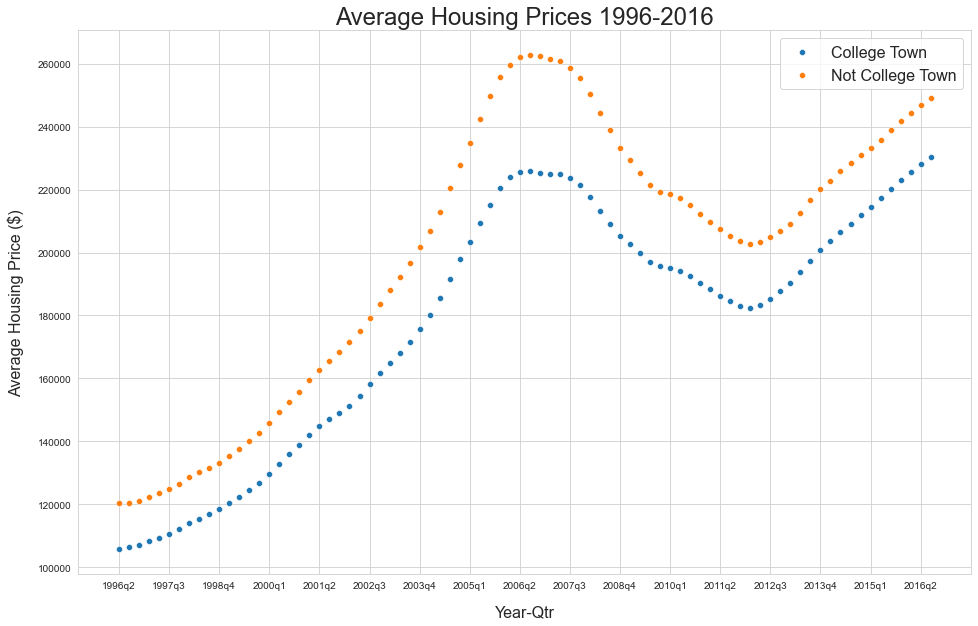

In [299]:
#plot average home price by quarter for college town and non college town
fig, ax = plt.subplots(figsize=(16,10))
college_town = sns.scatterplot(x=hp.index,y='College Town', data=hp, ax=ax)
not_college_town = sns.scatterplot(x=hp.index,y='Not College Town', data=hp, ax=ax)

#format x labels
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))

#plot titles and legend
plt.title('Average Housing Prices 1996-2016',fontsize=24)
plt.xlabel("Year-Qtr", labelpad=14, fontsize=16)
plt.ylabel("Average Housing Price ($)", labelpad=14, fontsize=16)
plt.legend(['College Town', 'Not College Town'], loc=1, fontsize=16)


# Run t-test

- H0: there is no difference between the mean price of houses in university towns the quarter before the recession starts compared to the end of the recession when compared to non-universirty towns vs. Ha there is a difference between the mean price in university towns compared to non university towns 
- test statistic: independent samples t-test statistic
- alpha = 0.95
- decision rule: if abs(t) > 1.96 reject H0, or if p-value < 0.05 reject H0
- Interpretation: if test statistic < -1.96, conclude with 95% confidence that price ratio is lower in college towns, implying prices are less affected during recession compared to non-college towns. If test statistic is > 1.96, then concluude prices are more affected in college towns.

In [333]:
#run ttest 

#create separate arrays for the two samples: college towns and non college towns
college_town = home_prices_by_quarter[home_prices_by_quarter['College Town']=='College Town']
non_college_town = home_prices_by_quarter[home_prices_by_quarter['College Town']=='Not College Town']
    
#run ttest for price ratio for time periods of interest
ttest_start_end = ttest_ind(college_town['Price_Ratio_Start_End'], non_college_town['Price_Ratio_Start_End'], nan_policy='omit')
ttest_start_bottom = ttest_ind(college_town['Price_Ratio_Start_Bottom'], non_college_town['Price_Ratio_Start_Bottom'], nan_policy='omit')
ttest_bottom_end = ttest_ind(college_town['Price_Ratio_Bottom_End'], non_college_town['Price_Ratio_Bottom_End'], nan_policy='omit')
ttest_runup = ttest_ind(college_town['Price_Ratio_Runup'], non_college_town['Price_Ratio_Runup'], nan_policy='omit')
ttest_recovery = ttest_ind(college_town['Price_Ratio_Recovery'], non_college_town['Price_Ratio_Recovery'], nan_policy='omit')


print(' TIME PERIOD   YEAR-QTR   TEST STATISTIC   P-VALUE',
      '\n','start-end', ' ', '2008q4-2009q4', '   ' "%.2f" % ttest_start_end[0], '      ', '%.3f' % ttest_start_end[1], 
      '\n','start-bot', ' ', '2008q4-2009q2', '   ' "%.2f" % ttest_start_bottom[0], '      ', '%.3f' % ttest_start_bottom[1], 
      '\n','bot-end  ', ' ', '2009q2-2009q4', '   ' "%.2f" % ttest_bottom_end[0], '      ', '%.3f' % ttest_bottom_end[1], 
      '\n','runup    ', ' ', '2001q1-2008q4', '   ' "%.2f" % ttest_runup[0], '       ', '%.3f' % ttest_runup[1], 
      '\n','recov    ', ' ', '2009q4-2016q3', '   ' "%.2f" % ttest_recovery[0], '      ', '%.3f' % ttest_recovery[1])

 TIME PERIOD   YEAR-QTR   TEST STATISTIC   P-VALUE 
 start-end   2008q4-2009q4    -2.70        0.007 
 start-bot   2008q4-2009q2    -2.23        0.026 
 bot-end     2009q2-2009q4    -2.51        0.012 
 runup       2001q1-2008q4    0.88         0.378 
 recov       2009q4-2016q3    -0.38        0.702


# Interpretation
- for all three time periods during the recession, housing prices in college towns are significantly less affected compared to housing prices in non-college towns.
- there is no significant relationship between college towns and housing price changes in the period leading up to the recession, or the recovery period after the recession.
- with these findings we can say that living in a college town is a good way to minimize the risk of housing price fluctuations during an economic recession.